In [25]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Load Dataframes

In [26]:
loaded_df = pd.read_parquet('turbofan_features.parquet', engine='pyarrow')
loaded_rul = pd.read_parquet('turbofan_RUL.parquet', engine='pyarrow')
loaded_df_test = pd.read_parquet('turbofan_features_test.parquet', engine='pyarrow')
loaded_rul_test = pd.read_parquet('turbofan_RUL_test.parquet', engine='pyarrow')

In [27]:
loaded_df

s_17__sum_values  s_3__sum_values  s_2__sum_values  s_4__length  \
1   42          13.750000        14.610639        13.945783         42.0   
    82          26.916667        27.715064        27.445783         82.0   
    122         42.500000        42.742533        43.045181        122.0   
    162         60.333333        59.914323        62.337349        162.0   
2   42          11.333333        11.070634         9.313253         42.0   
...                   ...              ...              ...          ...   
99  162         64.416667        60.467190        62.292169        162.0   
100 42          15.583333        15.649226        14.936747         42.0   
    82          32.166667        30.877044        30.454819         82.0   
    122         50.000000        47.556137        47.397590        122.0   
    162         69.250000        67.218879        68.250000        162.0   

         s_8__length  s_9__length  s_11__length  s_12__length  s_7__length  \
1   42          42.0         42.0          42.0          42.0         42.0   
    82          82.0         82.0          82.0          82.0         82.0   
    122        122.0        122.0         122.0         122.0        122.0   
    162        162.0        162.0         162.0         162.0        162.0   
2   42          42.0         42.0          42.0          42.0         42.0   
...              ...          ...           ...           ...          ...   
99  162        162.0        162.0         162.0         162.0        162.0   
100 42          42.0         42.0          42.0          42.0         42.0   
    82          82.0         82.0          82.0          82.0         82.0   
    122        122.0        122.0         122.0         122.0        122.0   
    162        162.0        162.0         162.0         162.0        162.0   

         s_13__length  ...  s_12__median  s_7__median  s_11__median  \
1   42           42.0  ...      0.713220     0.698873      0.252976   
    82           82.0  ...      0.698294     0.673913      0.264881   
    122         122.0  ...      0.678038     0.665056      0.309524   
    162         162.0  ...      0.646055     0.637681      0.333333   
2   42           42.0  ...      0.781450     0.770531      0.181548   
...               ...  ...           ...          ...           ...   
99  162         162.0  ...      0.665245     0.630435      0.333333   
100 42           42.0  ...      0.666311     0.636071      0.327381   
    82           82.0  ...      0.654584     0.634461      0.333333   
    122         122.0  ...      0.639659     0.605475      0.357143   
    162         162.0  ...      0.621535     0.581320      0.375000   

         s_17__median  s_8__root_mean_square  s_13__root_mean_square  \
1   42       0.333333               0.245494                0.250278   
    82       0.333333               0.247826                0.265209   
    122      0.333333               0.262432                0.277483   
    162      0.333333               0.290513                0.313082   
2   42       0.250000               0.162549                0.185601   
...               ...                    ...                     ...   
99  162      0.416667               0.280837                0.300360   
100 42       0.375000               0.250966                0.281971   
    82       0.416667               0.255535                0.272831   
    122      0.416667               0.267615                0.286138   
    162      0.416667               0.286250                0.308151   

         s_9__root_mean_square  s_13__mean  s_8__mean  s_9__mean  
1   42                0.128905    0.246849   0.240981   0.127322  
    82                0.128970    0.260222   0.243902   0.127248  
    122               0.127063    0.272420   0.257576   0.125608  
    162               0.124847    0.303377   0.282361   0.123341  
2   42                0.142718    0.177171   0.158009   0.141788  
...                        ...         

In [28]:
loaded_df_test.isna().sum().sum()

0

# Split in Training and Test Data

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_train, y_train = loaded_df, loaded_rul['my_series']
#X_validate, y_validate = loaded_df_test[loaded_df.columns], loaded_rul_test['my_series']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_validate = X_test
y_validate = y_test
#y_train = y_train.astype('object')
#le = LabelEncoder()
#y_train = le.fit_transform(y_train)
print(X_train.shape, X_validate.shape)

(343, 110) (115, 110)


# Hyperparameter Optimization

In [30]:
from sklearn.utils import class_weight
import numpy as np
print(np.unique(y_train))
# A array object that contains the weights for both classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)# A dictionary object containing key-value pairs of both classes and # their weights
class_weights_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2], 3: class_weights[3]}
print(class_weights)
#print(f”Our class weights:\n{class_weights_dict}”)

[0 1 2 3]
[1.04573171 1.36111111 0.88402062 0.8490099 ]


In [31]:
from skopt.space import Categorical, Integer
from skopt import BayesSearchCV
import numpy as np
np.int = int

rf = RandomForestClassifier(class_weight=class_weights_dict)

search_space = {
        "bootstrap": Categorical([True, False]),
        "max_depth": Integer(1, 20), 
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(10, 50),
        "min_samples_split": Integer(10, 50),
        "n_estimators": Integer(100, 1000)
    }

rf_opt = BayesSearchCV(rf, search_space, n_iter=250, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5
                                    )
_ = rf_opt.fit(X_train, y_train) 

c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point 

In [32]:
rf = _.best_estimator_
rf

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1.045731707317073,
                                     1: 1.3611111111111112,
                                     2: 0.884020618556701,
                                     3: 0.849009900990099},
                       max_depth=20, max_features='log2', min_samples_leaf=10,
                       min_samples_split=50, n_estimators=1000)

# Evaluation

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, multilabel_confusion_matrix
from sklearn import preprocessing

def evaluation(model, X, y, set="train"):
    y_hat = model.predict(X)
    lb = preprocessing.LabelBinarizer()
    y_lb = lb.fit_transform(y)
    y_hat_lb = lb.transform(y_hat)
    #confusion = multilabel_confusion_matrix(y_lb, y_hat_lb)
    #confusion
    print(f"roc score for {set} dataset: ", roc_auc_score(y_lb, y_hat_lb, average='macro'))
    print(f'Acc Score for {set} dataset: ', accuracy_score(y_lb, y_hat_lb))
    print(f'Precision Score for {set} dataset: ', precision_score(y_lb, y_hat_lb, average='macro'))
    print(f'Recall Score for {set} dataset: ', recall_score(y_lb, y_hat_lb, average='macro'))
    print(f'f1 score for {set} dataset: ', f1_score(y_lb, y_hat_lb, average='macro'))    

In [34]:
X_train.describe()

,s_17__sum_values,s_3__sum_values,s_2__sum_values,s_4__length,s_8__length,s_9__length,s_11__length,s_12__length,s_7__length,s_13__length,...,s_12__median,s_7__median,s_11__median,s_17__median,s_8__root_mean_square,s_13__root_mean_square,s_9__root_mean_square,s_13__mean,s_8__mean,s_9__mean
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,...,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000
mean,47.569485,46.463202,47.673224,123.399417,123.399417,123.399417,123.399417,123.399417,123.399417,123.399417,...,0.659551,0.635693,0.328023,0.375972,0.262733,0.282313,0.167651,0.277046,0.256731,0.164870
std,26.825263,26.232022,27.399618,62.672645,62.672645,62.672645,62.672645,62.672645,62.672645,62.672645,...,0.088108,0.077482,0.088015,0.058398,0.069070,0.068784,0.040260,0.069708,0.070221,0.038161
min,10.666667,10.698060,9.313253,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,0.471215,0.466989,0.154762,0.250000,0.137481,0.164542,0.084988,0.157563,0.129149,0.082873
25%,26.458333,25.422498,25.945783,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,...,0.587420,0.570048,0.251488,0.333333,0.199082,0.218873,0.141251,0.213585,0.192188,0.139762
50%,44.250000,42.742533,42.948795,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,0.655650,0.628824,0.333333,0.416667,0.262363,0.282185,0.168114,0.275466,0.254770,0.166507
75%,65.333333,63.496185,65.344880,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,...,0.737740,0.703704,0.400298,0.416667,0.325388,0.341946,0.190393,0.338235,0.319848,0.187518
max,155.333333,153.890342,159.966867,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,...,0.819829,0.785829,0.523810,0.500000,0.426918,0.440974,0.327155,0.434988,0.420642,0.298136


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 343 entries, (80, 82) to (23, 82)
Columns: 110 entries, s_17__sum_values to s_9__mean
dtypes: float64(110)
memory usage: 300.7 KB


In [36]:
evaluation(rf, X_train, y_train, set="train")
evaluation(rf, X_validate, y_validate, set="validate")

roc score for train dataset:  0.9054977736454812
Acc Score for train dataset:  0.8513119533527697
Precision Score for train dataset:  0.8554098537005164
Recall Score for train dataset:  0.8603035197553306
f1 score for train dataset:  0.8530573042891606
roc score for validate dataset:  0.881366688763407
Acc Score for validate dataset:  0.8
Precision Score for validate dataset:  0.7933816056910569
Recall Score for validate dataset:  0.8247903563941299
f1 score for validate dataset:  0.7941762138570648


In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

y_hat = rf.predict(X_t)
lb = preprocessing.LabelBinarizer()
y_lb = lb.fit_transform(y_validate)
y_hat_lb = lb.transform(y_hat)
confusion = confusion_matrix(y_lb, y_hat_lb)
confusion

NameError: name 'X_t' is not defined

In [15]:
rf.predict_proba(X_validate)

array([[2.82592138e-02, 4.34593891e-01, 4.61294833e-01, 7.58520621e-02],
       [6.02231300e-04, 1.10076363e-02, 4.14156392e-01, 5.74233740e-01],
       [7.85725359e-04, 3.21899154e-03, 2.77753865e-02, 9.68219897e-01],
       [1.57299334e-03, 1.45227391e-02, 4.94256324e-01, 4.89647944e-01],
       [4.68743248e-01, 4.56498721e-01, 6.77962958e-02, 6.96173495e-03],
       [5.92586618e-03, 2.13636861e-02, 4.95778006e-01, 4.76932441e-01],
       [1.87267295e-03, 1.55914828e-02, 7.00869508e-01, 2.81666337e-01],
       [1.02477681e-03, 1.37185514e-03, 9.19107647e-03, 9.88412292e-01],
       [0.00000000e+00, 5.37916296e-04, 1.44274235e-02, 9.85034660e-01],
       [5.80214112e-04, 1.03950127e-02, 5.58291931e-01, 4.30732843e-01],
       [2.95510616e-01, 5.66404220e-01, 1.28649024e-01, 9.43614040e-03],
       [2.98954916e-03, 1.56629425e-02, 6.43110855e-01, 3.38236654e-01],
       [5.73586601e-01, 3.66179123e-01, 5.72160533e-02, 3.01822344e-03],
       [5.02459208e-02, 5.76777812e-01, 3.29138910e

In [40]:
import joblib

joblib.dump(rf, "classification_model.joblib")

['classification_model.joblib']

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [38]:
cm = confusion_matrix(y_validate, rf.predict(X_validate))

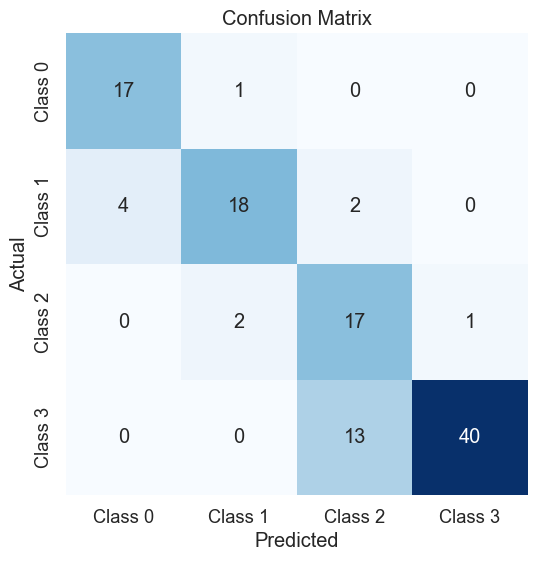

In [39]:
# Define class labels (change to your own class labels)
class_labels = ["Class 0", "Class 1", "Class 2", "Class 3"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, square=True,
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [44]:
for x in range(120):
    print(loaded_df.columns[x])


s_17__sum_values
s_3__sum_values
s_2__sum_values
s_4__length
s_8__length
s_9__length
s_11__length
s_12__length
s_7__length
s_13__length
s_3__length
s_15__length
s_17__length
s_20__length
s_2__length
s_21__length
s_15__sum_values
s_4__sum_values
s_11__sum_values
s_13__sum_values
s_8__sum_values
s_9__sum_values
s_20__sum_values
s_21__sum_values
s_7__sum_values
s_12__sum_values
s_11__variance
s_11__standard_deviation
s_4__variance
s_4__standard_deviation
s_12__variance
s_12__standard_deviation
s_20__variance
s_20__standard_deviation
s_7__standard_deviation
s_7__variance
s_4__absolute_maximum
s_4__maximum
s_13__variance
s_13__standard_deviation
s_3__maximum
s_3__absolute_maximum
s_21__minimum
s_11__absolute_maximum
s_11__maximum
s_15__standard_deviation
s_15__variance
s_20__minimum
s_15__absolute_maximum
s_15__maximum
s_17__absolute_maximum
s_17__maximum
s_21__standard_deviation
s_21__variance
s_7__minimum
s_12__minimum
s_9__variance
s_9__standard_deviation
s_17__variance
s_17__standard_de

IndexError: index 110 is out of bounds for axis 0 with size 110